<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script> 
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3.0.1/es5/tex-mml-chtml.js"></script>

# Figure 2: The putative D,D-carboxypeptidase BB0605 is an L,D-carboxypeptidase.
Code written by Joshua W. McCausland, CJW lab.

This encapsulates analysis and plotting for **Figure 3**. This encompasses constructing total ion chromatograms (TICs), extracted ion chromatograms (EICs), displaying representative images, and quantifying cell linescans. 

This is a large section that involves many packages and custom functions. See below for the setup for how I operate this script. 
- PG sacculus purification done by Elizabeth A. Mueller.
- PG digestion/MS completed by Irnov Irnov. 
- HADA imaging, analysis, and code completed by Joshua W. McCausland.

In [1]:
# import relevant packages. 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt,ticker
plt.rcParams["font.family"] = "Arial" #Set global font to arial
import glob,os
import warnings
import seaborn as sns
from skimage.io import imread
warnings.filterwarnings("ignore")
from pymzml.run import Reader

# This is a pallet of color blind friendly colors.
CB_color_cycle = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00',
} 

# For defining y scale in axes.
def y_fmt(x, y):
    return f'{x/1e4:.1f}'.format(x).split('e')[0]


# For making EICs. 
def refine_mass(df,ppm = 20,mass_to_search = 0):
    low_mass = mass_to_search - (ppm*mass_to_search/1e6)
    high_mass = mass_to_search + (ppm*mass_to_search/1e6)
    result = df.apply(lambda row: np.sum(row.peaks[np.where(np.logical_and(row.mz >= low_mass, row.mz <= high_mass))]) if row.peaks[np.where(np.logical_and(row.mz > low_mass, row.mz < high_mass))].shape[0] > 0 else 0,axis=1)
    return result

# source directory on the lab server.
#experiment_directory = '/Volumes/Common/Science communication/Manuscripts/Papers/2024/Bb PG shedding/Draft_figures/SourceData/Fig3'
experiment_directory = '//mothership2.stanford.edu/Common\Science communication/Manuscripts/Papers/2024/Bb PG shedding/Draft_figures/SourceData/Fig3'

## Figure 3A. TICs of parent (5A18NP1) and *bb0605*::Himar*1* (T08TC493). 
Here I sum all peaks at every time for the total ion chromatogram. 

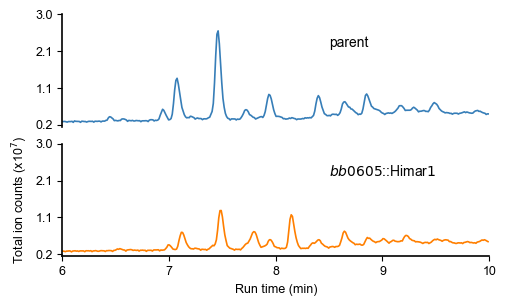

In [2]:
# identify the converted mzML files in pickle format.
filelist = glob.glob(f'{experiment_directory}/dataframes/pg_digestion_pkl_data/*EAM*')

# open those files, concatenate them into one matrix with a strain identifier
concatenated_mz = pd.DataFrame()
for file in filelist:
    filename = os.path.basename(file).removesuffix('.pkl')
    _strain = filename.split('_')[2]
    temp_df = pd.read_pickle(file)
    temp_df['strain'] = np.repeat(_strain,temp_df.shape[0])
    concatenated_mz = pd.concat([concatenated_mz,temp_df])

# calculate TIC by summing all the peaks. 
concatenated_mz['tic'] = concatenated_mz.peaks.apply(np.sum)

# PG species of interest fall within the 6-10 minute mark.
time_window = [6,10]

#iterable values.
CBcolors = ['blue','orange']
labels = ['parent','$bb0605$::Himar$1$']

#y scaling for axes
def y_fmt(x, y):
    return f'{(x/1e7):<2.1f}'.format(x).split('e')[0]

# plot the TICs
fig,axs = plt.subplots(nrows=2,figsize=[5,3],layout = 'constrained')
for ax,grouped,CBcolor,_label in zip(axs,concatenated_mz.groupby('strain'),CBcolors,labels):
    strain,grp = grouped
    grp = grp[grp.time.between(time_window[0],time_window[1])]
    ax.plot(grp.time,grp.tic,color = CB_color_cycle[CBcolor],linewidth=1.2)
    ax.tick_params(axis='both',labelsize=9)
    ax.set_xlim(time_window)
    ax.set_xticks([6,7,8,9,10])
    if strain == 'Bb144':
        ylims = ax.get_ylim()
        yaxis_scale = np.diff(ylims)/5
    ax.spines[['right','top']].set_visible(False)
    ax.spines[['bottom','left']].set_linewidth(1.2)
    ax.set_yticks(np.linspace(0.2e7,3e7,4))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    ax.text(8.5,ylims[1]-yaxis_scale,_label)

axs[0].set_xticks([])
axs[0].spines['bottom'].set_visible(False)
axs[1].set_ylabel('Total ion counts (x10$^7$)',fontsize=9)
axs[1].set_ylim(axs[0].get_ylim())
ax.set_xlabel('Run time (min)',fontsize=9)
fig.tight_layout(pad=0.5)

# Figure 3B-C. Extracted ion chromatograms of select PG species with or without terminal D-Ala-D-Ala.

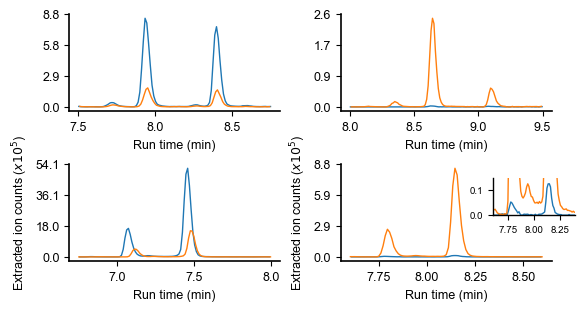

In [3]:
# we want to compare regular MurNAc and anhMurNAc species. 
species_to_plot = ['ZAEOG','XAEOG','ZAEOAAG','XAEOAAG']

# define the yscale.
def y_fmt(x, y):
    return f'{(x/1e5):<2.1f}'.format(x).split('e')[0]

# identify the pickle-converted mzML files.
filelist = glob.glob(f'{experiment_directory}/dataframes/pg_digestion_pkl_data/*EAM*')

# Pull up the reference dataframe for PG species and pull out just the ones we're interested in.
reference_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)].set_index('Species')

# define time windows for plotting the EICs.
species_time_dict = {
    'XAEOG': [6.75,8],
    'ZAEOG': [7.5,8.75],
    'XAEOAAG': [7.6,8.6],
    'ZAEOAAG': [8,9.5]
}

# open the mzML pickle files, concatenate them into one matrix with a strain identifier
concatenated_mz = pd.DataFrame()
for file in filelist:
    filename = os.path.basename(file).removesuffix('.pkl')
    _strain = filename.split('_')[2]
    temp_df = pd.read_pickle(file)
    temp_df['strain'] = np.repeat(_strain,temp_df.shape[0])
    concatenated_mz = pd.concat([concatenated_mz,temp_df])

# construct EICs for each of the PG species.
for _species in species_to_plot:
    concatenated_mz[_species] = refine_mass(df=concatenated_mz,ppm=20,mass_to_search=reference_df['mz_plus_1'].loc[_species])


fig, axs = plt.subplots(ncols=2, nrows=2,figsize = [5.5,3],layout = 'constrained')

# iterate through every axis and plot its PG species
for _ax,_species in zip(axs.T.ravel(),species_to_plot):
    time_window = species_time_dict[_species]
    temp_df = concatenated_mz[concatenated_mz.time.between(time_window[0],time_window[1])]
    sns.lineplot(data=temp_df,x='time',y=_species,hue='strain',ax=_ax,legend=False,linewidth=1)
    _ax.spines[['right','top']].set_visible(False)
    _ax.spines[['bottom','left']].set_linewidth(1.2)  
    _ax.tick_params(axis='both',labelsize=9)
    _ax.set_xlabel('Run time (min)',fontsize=9)
    _ax.set_ylabel('')
    ylims = _ax.get_ylim()
    _ax.set_yticks(np.linspace(0,ylims[1],4))
    _ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

axs[1,0].set_ylabel('Extracted ion counts ($x10^5$)',fontsize=9)
axs[1,1].set_ylabel('Extracted ion counts ($x10^5$)',fontsize=9)

# create a tiny axis window for the zoom-in of GlcNAc-MurNAc-Ala-Glu-Orn(Gly)-Ala-Ala
tiny_ax = fig.add_axes([0.885, 0.3, 0.15, 0.125])
time_window = species_time_dict['XAEOAAG']
temp_df = concatenated_mz[concatenated_mz.time.between(time_window[0],time_window[1])]
sns.lineplot(data=temp_df,x='time',y='XAEOAAG',hue='strain',ax=tiny_ax,legend=False,linewidth=1)
tiny_ax.spines[['right','top']].set_visible(False)
tiny_ax.spines[['bottom','left']].set_linewidth(1.2)  
tiny_ax.set_ylabel('')
tiny_ax.set_xlabel('')
tiny_ax.set_xlim([7.6,8.4])    
tiny_ax.set_ylim([0,1.5e4])
tiny_ax.tick_params(axis='both', labelsize=7)
tiny_ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
tiny_ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
tiny_ax.spines[['right','top']].set_visible(False)
tiny_ax.spines[['bottom','left']].set_linewidth(1)  

## Figure 3D-E. Representative images of *Borrelia* stained with HADA
I previously identified representative cells in FIJI and cropped out regions of equivalant sizes. I saved the phase contrast and fluorescent regions as separate TIFs to load in for this figure generation. 

First, let's define a couple more functions to help display these image regions. The purpose of these is to create a boundary around the fluorescent image to denote *where* the cells are. This will segment the phase contrast images, binarizing them and dilating them to find the contour (outer boundary) that surrounds the cell. 

In [4]:
# relevant imaging packages. 
from scipy.ndimage import binary_fill_holes,binary_dilation
from skimage.measure import label
from skimage.segmentation import clear_border
import cv2

# this helps identify the coordinates for the segmented cell.
def get_indices_pandas(data):
    d = data.ravel()
    f = lambda x: np.unravel_index(x.index, data.shape)
    return pd.Series(d).groupby(d).apply(f)

# Feed the phase contrast image to this function, and it returns the contour (boundary of the cell)
#   - Smooth the image with a median filter, then use the adaptive threshold from cv2 to binarize it. 
#   - fill holes/aberrations if any exist in the mask. 
#   - label all objects in the binarized images. 
#   - Remove objects touching the boundary of the image (cells that are cropped)
#   - dilate the binary object (cell) several times to make it bigger than the original. This helps when making the contour. 
#   - Grab the coordinates of this mask, then find the contour. 
def adaptive_threshold_contours(img,footprint = 7):
    sensor = img.shape
    img = cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    img = cv2.medianBlur(img,9)
    bw = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,footprint,3)
    bw = binary_fill_holes(np.invert(bw))
    bw = bw.astype('int')
    ccs = label(bw)
    component_sizes = np.bincount(ccs.ravel())
    too_small = component_sizes < 500
    too_small_mask = too_small[ccs]
    ccs[too_small_mask] = 0
    ccs = clear_border(ccs,buffer_size = 5)
    ccs = binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(ccs)))))
    ccs = label(ccs)
    cell_contours = []
    cell_coords = get_indices_pandas(ccs)
    for cell_coord in cell_coords:
        temp_mask = np.full(sensor,fill_value=0)
        temp_mask[cell_coord[0],cell_coord[1]] = 255
        contours,_ = cv2.findContours(temp_mask.astype('uint8'),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cell_contours.append(np.vstack(np.vstack(contours)))
    return cell_contours

Display the representative images.

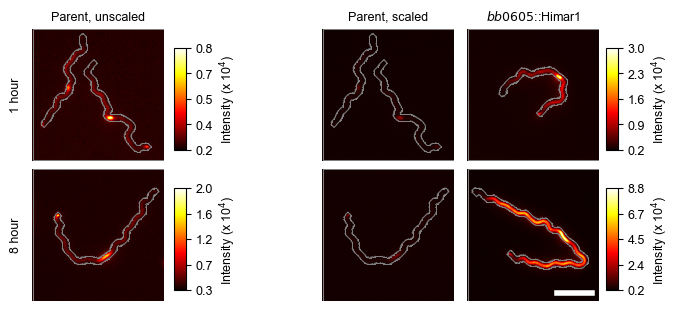

In [5]:
# Editable components for this script. The most relevant is the colormap ("_cmap")

_cmap = 'hot' # Colormap for showing the images.
label_name = 'Intensity (x 10$^4$)' #label for all colormap scales.
scale_bar_size = 5 #answer in microns
crop_window = 28 # Window to crop in pixels.

#####################################################################################
def y_fmt(x, y):
    return f'{(x/1e4):<2.1f}'.format(x).split('e')[0]

px_for_scale_bar = scale_bar_size/0.065 #divide the scale bar size by the pixel size

# Load the respective images for this figure, then crop them. 
# Phase images first. I want to extract their contours so I can draw cell boundaries.
# Crop the images to remove other cells that are distracting.
bb144_1hr = imread(f'included_small_datasets/HADA_tifs/Bb144_1hr-Phase.tif')[crop_window-10:-crop_window-10,crop_window:-crop_window] #Adjust the window by 10 pixels to center the cells.
bb144_8hr = imread(f'included_small_datasets/HADA_tifs/Bb144_8hr-Phase.tif')[crop_window:-crop_window,crop_window-17:-crop_window-17]
bb54_1hr = imread(f'included_small_datasets/HADA_tifs/Bb54_1hr-Phase.tif')[crop_window:-crop_window,crop_window:-crop_window]
bb54_8hr = imread(f'included_small_datasets/HADA_tifs/Bb54_8hr-Phase.tif')[crop_window:-crop_window,crop_window:-crop_window]

# Combine all the phase images into one array then extract their contours. 
phase_ims = np.array([bb144_1hr,bb144_8hr,bb54_1hr,bb54_8hr])
contours = [adaptive_threshold_contours(phase_im) for phase_im in phase_ims]

# Load all the fluorescent images. 
bb144_1hr = imread(f'included_small_datasets/HADA_tifs/Bb144_1hr-HADA.tif')[crop_window-10:-crop_window-10,crop_window:-crop_window] #Adjust the window by 10 pixels to center the cells.
bb144_8hr = imread(f'included_small_datasets/HADA_tifs/Bb144_8hr-HADA.tif')[crop_window:-crop_window,crop_window-17:-crop_window-17]
bb54_1hr = imread(f'included_small_datasets/HADA_tifs/Bb54_1hr-HADA.tif')[crop_window:-crop_window,crop_window:-crop_window]
bb54_8hr = imread(f'included_small_datasets/HADA_tifs/Bb54_8hr-HADA.tif')[crop_window:-crop_window,crop_window:-crop_window]


# This is to scale the images to the same min and max intensity values.
min_bit_value_1hr = np.min(np.concatenate([bb144_1hr,bb54_1hr]))
max_bit_value_1hr = np.max(np.concatenate([bb144_1hr,bb54_1hr]))

min_bit_value_8hr = np.min(np.concatenate([bb144_8hr,bb54_8hr]))
max_bit_value_8hr = np.max(np.concatenate([bb144_8hr,bb54_8hr]))

#plot the images.
fig,axs = plt.subplots(nrows=2,ncols=4,figsize=[6,3],layout='constrained')
cax1 = axs[0,2].imshow(bb144_1hr,cmap=f'{_cmap}',vmin=min_bit_value_1hr,vmax=max_bit_value_1hr)
axs[0,3].imshow(bb54_1hr,cmap=f'{_cmap}',vmin=min_bit_value_1hr,vmax=max_bit_value_1hr)
cax2 = axs[1,2].imshow(bb144_8hr,cmap=f'{_cmap}',vmin=min_bit_value_8hr,vmax=max_bit_value_8hr)
axs[1,3].imshow(bb54_8hr,cmap=f'{_cmap}',vmin=min_bit_value_8hr,vmax=max_bit_value_8hr)
cax3 = axs[0,0].imshow(bb144_1hr,cmap=f'{_cmap}',vmin = np.min(bb144_1hr)+100)

#Add contours (cell boundaries) to plots. 
contour_temp = contours[0]
for _contour in contour_temp:
    for idx in np.arange(len(_contour)+1):
        if idx < len(_contour):
            step = np.column_stack([_contour[idx-1],_contour[idx]])
            axs[0,0].plot(step[0],step[1],'-',color='gray',linewidth=0.75)
cax4 = axs[1,0].imshow(bb144_8hr,cmap=f'{_cmap}',vmin = np.min(bb144_8hr)+300)
contour_temp = contours[1]
for _contour in contour_temp:
    for idx in np.arange(len(_contour)+1):
        if idx < len(_contour):
            step = np.column_stack([_contour[idx-1],_contour[idx]])
            axs[1,0].plot(step[0],step[1],'-',color='gray',linewidth=0.75)

#scale bar
axs[1,3].plot([200,200+px_for_scale_bar],[275,275],'-',color='white',linewidth=4)

#Add contours (cell boundaries) to plots. 
for contours_temp,ax in zip(contours,axs.T.ravel()[4:]):
    for _contour in contours_temp:
        for idx in np.arange(len(_contour)+1):
            if idx < len(_contour):
                step = np.column_stack([_contour[idx-1],_contour[idx]])
                ax.plot(step[0],step[1],'-',color='gray',linewidth=0.75)

# labels.
axs[0,2].set_title('Parent, scaled',fontsize=9)
axs[0,0].set_title('Parent, unscaled',fontsize=9)
axs[0,3].set_title('$bb0605$::Himar1',fontsize=9)
axs[0,0].set_ylabel('1 hour',fontsize=9)
axs[1,0].set_ylabel('8 hour',fontsize=9)

# now add colorbars for intensity scaling context. 
width_height = [0.02,0.34]
cbar_ax1 = fig.add_axes([1,0.5175]+width_height)
cbar = fig.colorbar(cax1, cax=cbar_ax1,orientation='vertical')
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_ylabel(f'{label_name}',fontsize=9)
cbar.ax.set_yticks(np.linspace(min_bit_value_1hr,max_bit_value_1hr,5))
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

cbar_ax2 = fig.add_axes([1,0.05]+width_height)
cbar = fig.colorbar(cax2, cax=cbar_ax2,orientation='vertical')
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_ylabel(f'{label_name}',fontsize=9)
cbar.ax.set_yticks(np.linspace(min_bit_value_8hr,max_bit_value_8hr,5))
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

min_bit_value_144_1hr = np.min(bb144_1hr)+100
max_bit_value_144_1hr = np.max(bb144_1hr)

cbar_ax3 = fig.add_axes([0.28,0.5175]+width_height)
cbar = fig.colorbar(cax3, cax=cbar_ax3,orientation='vertical')
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_ylabel(f'{label_name}',fontsize=9)
cbar.ax.set_yticks(np.linspace(min_bit_value_144_1hr,max_bit_value_144_1hr,5))
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

min_bit_value_144_8hr = np.min(bb144_8hr)+300
max_bit_value_144_8hr = np.max(bb144_8hr)

cbar_ax4 = fig.add_axes([0.28,0.05]+width_height)
cbar = fig.colorbar(cax4, cax=cbar_ax4,orientation='vertical')
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_ylabel(f'{label_name}',fontsize=9)
cbar.ax.set_yticks(np.linspace(min_bit_value_144_8hr,max_bit_value_144_8hr,5))
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

# Since these are images, remove all graph lines and ticks.
for ax in axs.ravel():
    ax.spines[['top','right','left','bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

## Figure 3F. Average linescans for parent vs. *bb0605*::Himar*1*

In separate code included with this manuscript ("Borrelia_Cell_Segmentation"), all images were segmented and cell flurescence data was stored in a single Pandas dataframe (called "pooled_data_medial_axis.pkl"). Here, we load the prepared dataframe and plot linescans.

First, the section below defines a custom function which makes demographs. 
- The purpose is to arrange linescans from shortes to longest, and center them to one another. 
- Average the linescans along the cell length positions to get an average linscan. 
- The function outself just outputs a numpy matrix with all the arranged linescans. 

In [6]:

# Calculating moving average in demographs later. Assumes a rolling window of 3 units.
def moving_average(a, n=3):
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# This makes a demograph of cell linescans. 
def make_demograph(df):
    # grab the sizes of all linescans (total steps)
    df['sizes'] = df.linescan.apply(lambda x: x.shape[0])
    
    # sort linescans from shortest to longest.
    df = df.sort_values('sizes')
    df = df.reset_index()

    # make an empty numpy matrix, slightly bigger than the longeset linescan, and populate with NaNs.
    demo = np.empty([df.sizes.max()+1,df.shape[0]])
    demo[:] = np.nan

    # determine the half-way point in the demograph for aligning the lines.
    half_width = np.ceil(df.sizes.max()/2).astype(int)

    # iterate through linescans and add them to the demograph matrix.
    for index,row in df.iterrows():
        linescan = row.linescan
        # Calculate a rolling average with a window of 10 steps.
        # This smooths out the linescan to emphasize big picture patterns (like midcell enrichment)
        linescan_av = moving_average(linescan,n=10)

        # align linescans at the middle.
        linescan_bottom = np.floor(len(linescan_av)/2).astype(int)
        linescan_top = np.ceil(len(linescan_av)/2).astype(int)
        demo[half_width-linescan_bottom:half_width+linescan_top,index] = linescan_av

        arc_length = df.iloc[-1].arc_length
        
    return demo,arc_length


Use the demograph function twice here. 
1) Calculate the average linescan for each biological replicate (3 replicates)
2) Calculate the average linescan of the biological replicates. 

Text(0, 0.5, 'Mean intensity (x10$^4$)')

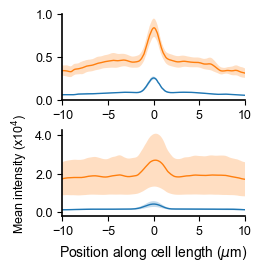

In [10]:
# The cell dataframe is very large and takes some time to load. While building this chunk, I only opted to load it once if it wasn't already there to save time.
if 'cell_df' not in locals():
    cell_df = pd.read_pickle(f'{experiment_directory}/dataframes/pooled_data_medial_axis.pkl').drop(['CellCoord','frame','skel_coords','thickness','width','cell_im','CellID','medialaxis'],axis=1)
    
    # I imaged for [1,2,4,8] hours. Only need to show [1,8] for the manuscript.
    cell_df = cell_df[cell_df.Time.isin([1,8])]

demo_df = pd.DataFrame()
idx = 0
for key,grp in cell_df.groupby(by = ['Strain','Time','Replicate']):

    # this is the demograph function defined above.
    demo,arc_length = make_demograph(grp)

    # calculate the mean linescan of each replicate ("mean_demo")
    temp_df = pd.DataFrame({
        'mean_demo': [np.nanmean(demo,axis=1)],
        'strain': key[0],
        'time': key[1],
        'rep': key[2],
        'size': demo.shape[0],
        'arc_length': [arc_length] 
    },dtype='object')
    idx += 1
    demo_df = pd.concat([demo_df,temp_df],axis=0)
demo_df['strain-time'] = demo_df.apply(lambda row: f'{row.strain}-{row.time}',axis=1)

demo_biolrep_df = pd.DataFrame()
idx = 0
for key,grp in demo_df.groupby('strain-time'):
    grp['linescan'] = grp['mean_demo']
    demo,arc_length = make_demograph(grp)
    temp_df = pd.DataFrame({
        'mean_demo': [np.nanmean(demo,axis=1)], #average linescan of the biological replicates
        'std_demo': [np.nanstd(demo,axis=1)/np.sqrt(3)], # linescan standard error of the biological replicates.
        'strain': key.split('-')[0],
        'time': int(key.split('-')[1]),
        'size': demo.shape[0],
        'arc_length': [arc_length]
    },index = [idx],dtype='object')
    idx += 1
    demo_biolrep_df = pd.concat([demo_biolrep_df,temp_df],axis=0)


# plot the average linescans. 
fig,axs = plt.subplots(nrows = 2,layout = 'constrained',figsize = [2.5,2.6])
for grouped,_ax in zip(demo_biolrep_df.groupby('time'),axs):
    _time = grouped[0]
    grp = grouped[1]

    for strain,subgrp in grp.groupby('strain'):
        arc_length = subgrp.arc_length.iloc[0] - np.median(subgrp.arc_length.iloc[0])
        mean_linescan = subgrp.mean_demo.iloc[0]
        std_linescan = subgrp.std_demo.iloc[0]

        _ax.plot(arc_length,mean_linescan[1:-1],label = key,linewidth=1)
        _ax.fill_between(arc_length, mean_linescan[1:-1]-std_linescan[1:-1],  mean_linescan[1:-1]+std_linescan[1:-1],alpha=0.25)

    _ax.spines[['right','top']].set_visible(False)
    _ax.spines[['bottom','left']].set_linewidth(1.2)
    _ax.set_xlim([-10,10])
    _ax.tick_params(axis='both',labelsize=9)
    ylims = _ax.get_ylim()

    #_ax.set_yticks(np.linspace(0,ylims[1],4))
    _ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    _ax.set_ylim(ylims)

axs[0].set_ylim([0,1e4])
axs[1].set_xlabel('Position along cell length ($\mu$m)')
axs[1].set_ylabel(f'Mean intensity (x10$^4$)',fontsize=9)